In [81]:
import pandas as pd
import numpy as np
import statsmodels.tsa.api as smt
from sklearn.model_selection import train_test_split
import statsmodels as sm
from statsmodels.regression.linear_model import OLS
from sklearn.metrics import r2_score
import seaborn as sbn
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [82]:
forex_data = pd.read_csv("FX_USDJPY_201701till01312259.csv", header=None)

In [83]:
forex_data.columns = ['Date','Time','Open','High','Low','Close']

In [84]:
forex_data.head()

,Date,Time,Open,High,Low,Close
0,2017.01.02,2:00,116.858,116.870,116.858,116.870
1,2017.01.02,2:01,116.875,116.915,116.875,116.901
2,2017.01.02,2:02,116.901,116.901,116.901,116.901
3,2017.01.02,2:03,116.901,116.906,116.897,116.900
4,2017.01.02,2:04,116.900,116.903,116.900,116.903


## 2.3 Pre-process FOREX currency data for model input

In [85]:
forex_data["Hour"] = forex_data["Time"].apply(lambda t: t.split(":")[0])
forex_data["Hour"] = forex_data["Hour"].astype(int)
forex_data.head()

,Date,Time,Open,High,Low,Close,Hour
0,2017.01.02,2:00,116.858,116.870,116.858,116.870,2
1,2017.01.02,2:01,116.875,116.915,116.875,116.901,2
2,2017.01.02,2:02,116.901,116.901,116.901,116.901,2
3,2017.01.02,2:03,116.901,116.906,116.897,116.900,2
4,2017.01.02,2:04,116.900,116.903,116.900,116.903,2


#### Take the mean of closing price for every hour

In [86]:
forex_agg = forex_data.groupby(["Date","Hour"])["Close"].mean()
forex_agg = forex_agg.reset_index().sort_values(by=["Date","Hour"],ascending=True)

In [87]:
forex_agg.head()

,Date,Hour,Close
0,2017.01.02,2,116.997768
1,2017.01.02,3,117.325172
2,2017.01.02,4,117.401138
3,2017.01.02,5,117.403000
4,2017.01.02,6,117.356714


In [88]:
len(forex_agg)

525

In [89]:
forex_agg.columns

Index(['Date', 'Hour', 'Close'], dtype='object')

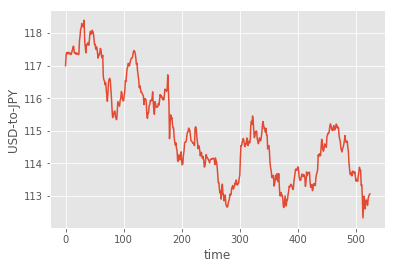

In [90]:
import matplotlib.pyplot as plt
plt.xlabel('time')
plt.ylabel('USD-to-JPY')
plt.plot(forex_agg['Close'])

There is certainly a downtrend

### Moving Average and RSI based Features

In [91]:
for i in range(1,7):
    forex_agg['close_lag' + str(i)] = forex_agg['Close'].shift(i)

In [92]:
import talib

Formula for RS = average gain over n periods/average loss over n periods

RSI = 100 - (100/(1 + RS))

In [93]:
for n in [6,12,18,24]:

    # Create the moving average and divide by the close price to average it out
    forex_agg['ma_' + str(n)] = talib.SMA(forex_agg['Close'].values,
                              timeperiod=n) / forex_agg['Close']
    # Create the RSI indicator
    forex_agg['rsi_' + str(n)] = talib.RSI(forex_agg['Close'].values, timeperiod=n)
forex_agg.head(10)

,Date,Hour,Close,close_lag1,close_lag2,close_lag3,close_lag4,close_lag5,close_lag6,ma_6,rsi_6,ma_12,rsi_12,ma_18,rsi_18,ma_24,rsi_24
0,2017.01.02,2,116.997768,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017.01.02,3,117.325172,116.997768,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017.01.02,4,117.401138,117.325172,116.997768,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017.01.02,5,117.403000,117.401138,117.325172,116.997768,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017.01.02,6,117.356714,117.403000,117.401138,117.325172,116.997768,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2017.01.02,7,117.408610,117.356714,117.403000,117.401138,117.325172,116.997768,NaN,0.999206,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2017.01.02,8,117.391678,117.408610,117.356714,117.403000,117.401138,117.325172,116.997768,0.999909,87.850791,NaN,NaN,NaN,NaN,NaN,NaN
7,2017.01.02,9,117.361983,117.391678,117.408610,117.356714,117.403000,117.401138,117.325172,1.000215,82.220302,NaN,NaN,NaN,NaN,NaN,NaN
8,2017.01.02,10,117.384917,117.361983,117.391678,117.408610,117.356714,117.403000,117.401138,0.999996,83.217167,NaN,NaN,NaN,NaN,NaN,NaN
9,2017.01.02,11,117.339186,117.384917,117.361983,117.391678,117.408610,117.356714,117.403000,1.000295,73.373269,NaN,NaN,NaN,NaN,NaN,NaN


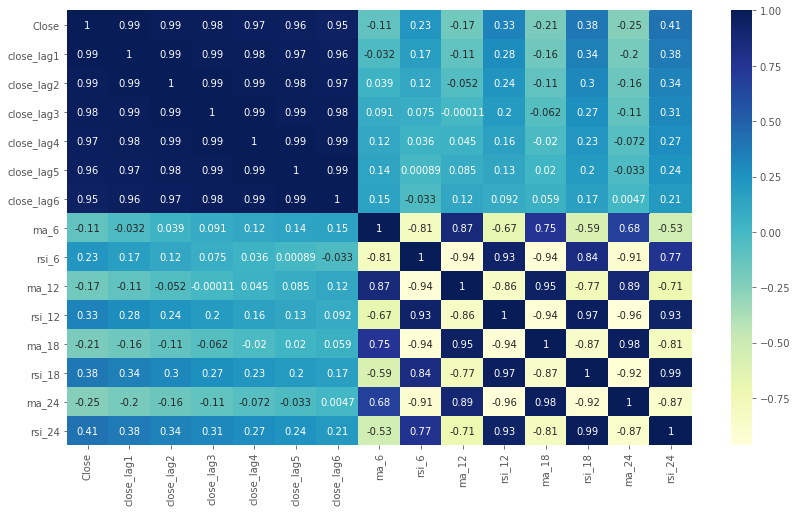

In [94]:
import seaborn as sbn
plt.figure(figsize=(14,8))
corr = forex_agg.drop(columns=["Date","Hour"]).corr()
sbn.heatmap(data=corr, annot=True, cmap="YlGnBu")

### Data Cleaning and Outlier Detection

#### Check for null or na on columns

In [95]:
forex_agg.isna().sum()

Date           0
Hour           0
Close          0
close_lag1     1
close_lag2     2
close_lag3     3
close_lag4     4
close_lag5     5
close_lag6     6
ma_6           5
rsi_6          6
ma_12         11
rsi_12        12
ma_18         17
rsi_18        18
ma_24         23
rsi_24        24
dtype: int64

In [96]:
forex_agg.fillna(forex_agg.mean(),inplace=True)

In [97]:
forex_agg.isna().sum()

Date          0
Hour          0
Close         0
close_lag1    0
close_lag2    0
close_lag3    0
close_lag4    0
close_lag5    0
close_lag6    0
ma_6          0
rsi_6         0
ma_12         0
rsi_12        0
ma_18         0
rsi_18        0
ma_24         0
rsi_24        0
dtype: int64

In [98]:
# Computing IQR
Q1 = forex_agg[["Close"]].quantile(0.25)
Q3 = forex_agg[["Close"]].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Close    2.2943
dtype: float64


In [99]:
import matplotlib.pyplot as plt
import seaborn as sbn
plt.style.use('ggplot')

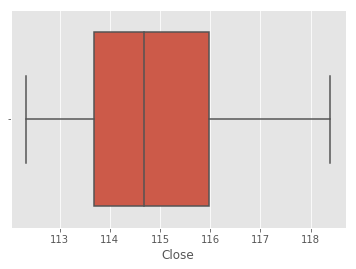

In [100]:
sbn.boxplot("Close", data=forex_agg)
# plt.xscale("log")

In [101]:
len(forex_agg[forex_agg.Close > Q3['Close'] + 1.5*IQR[0]]) * 100/len(forex_agg)

0.0

In [102]:
len(forex_agg[forex_agg.Close < Q3['Close'] - 1.5*IQR[0]]) * 100/len(forex_agg)

0.19047619047619047

There are no outliers

# 2.4 Build the linear regression model

In [103]:
from sklearn.model_selection import train_test_split

Dropping **time** columns as they do not have significance as a driver for closing price.

In [104]:
forex_final = forex_agg.drop(columns = ["Date","Hour"], axis = 1)

In [105]:
forex_final.head()

,Close,close_lag1,close_lag2,close_lag3,close_lag4,close_lag5,close_lag6,ma_6,rsi_6,ma_12,rsi_12,ma_18,rsi_18,ma_24,rsi_24
0,116.997768,114.959874,114.963539,114.967309,114.971227,114.975556,114.979731,1.000184,48.969754,1.00042,48.274891,1.00067,47.959718,1.000896,47.79035
1,117.325172,116.997768,114.963539,114.967309,114.971227,114.975556,114.979731,1.000184,48.969754,1.00042,48.274891,1.00067,47.959718,1.000896,47.79035
2,117.401138,117.325172,116.997768,114.967309,114.971227,114.975556,114.979731,1.000184,48.969754,1.00042,48.274891,1.00067,47.959718,1.000896,47.79035
3,117.403000,117.401138,117.325172,116.997768,114.971227,114.975556,114.979731,1.000184,48.969754,1.00042,48.274891,1.00067,47.959718,1.000896,47.79035
4,117.356714,117.403000,117.401138,117.325172,116.997768,114.975556,114.979731,1.000184,48.969754,1.00042,48.274891,1.00067,47.959718,1.000896,47.79035


#### Normalise the data

In [106]:
forex_n = forex_final.loc[:, forex_final.columns != 'Close']

In [107]:
forex_n = (forex_n - forex_n.mean()) / forex_n.std()

In [108]:
forex_m = pd.concat([forex_n,forex_final.loc[:,'Close']],axis=1)

In [109]:
forex_m.head()

,close_lag1,close_lag2,close_lag3,close_lag4,close_lag5,close_lag6,ma_6,rsi_6,ma_12,rsi_12,ma_18,rsi_18,ma_24,rsi_24,Close
0,-1.917938e-14,-9.605073e-15,-1.924272e-14,-9.638977e-15,-9.660532e-15,-9.680626e-15,-1.148807e-13,3.216946e-16,7.415790e-14,0.0,5.881970e-14,1.097671e-15,4.916944e-14,0.0,116.997768
1,1.375201e+00,-9.605073e-15,-1.924272e-14,-9.638977e-15,-9.660532e-15,-9.680626e-15,-1.148807e-13,3.216946e-16,7.415790e-14,0.0,5.881970e-14,1.097671e-15,4.916944e-14,0.0,117.325172
2,1.596138e+00,1.374929e+00,-1.924272e-14,-9.638977e-15,-9.660532e-15,-9.680626e-15,-1.148807e-13,3.216946e-16,7.415790e-14,0.0,5.881970e-14,1.097671e-15,4.916944e-14,0.0,117.401138
3,1.647400e+00,1.596220e+00,1.374708e+00,-9.638977e-15,-9.660532e-15,-9.680626e-15,-1.148807e-13,3.216946e-16,7.415790e-14,0.0,5.881970e-14,1.097671e-15,4.916944e-14,0.0,117.403000
4,1.648657e+00,1.647565e+00,1.596375e+00,1.374567e+00,-9.660532e-15,-9.680626e-15,-1.148807e-13,3.216946e-16,7.415790e-14,0.0,5.881970e-14,1.097671e-15,4.916944e-14,0.0,117.356714


In [110]:
X = forex_m.loc[:, forex_m.columns != 'Close']
Y = forex_m['Close']

In [111]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,random_state=42, test_size=0.2)

In [112]:
print("Length Of training data ", len(X_train))
print("Length Of test data ", len(X_test))
print("Length Of training Y ", len(Y_train))
print("Length Of test data Y", len(Y_test))

Length Of training data  420
Length Of test data  105
Length Of training Y  420
Length Of test data Y 105


In [113]:
def linear_reg(y_train, X_train, isSummary=False):
    """ A function that formulates the linear regression model for a the input training dataset
    @Author Aryan Singh
    """
    #Constitute a Linear Regression Model
    
    # Add a bias column to the training dataset before fitting the model
    X_train = sm.tools.tools.add_constant(X_train, has_constant='add')
    lm_1 = OLS(y_train,X_train).fit()
    
    if isSummary:
        #Visualise the results of the model
        print(lm_1.summary())
    return lm_1

In [114]:
mod = linear_reg(Y_train, X_train, isSummary=True)

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 1.079e+04
Date:                Mon, 30 Mar 2020   Prob (F-statistic):               0.00
Time:                        17:17:07   Log-Likelihood:                 485.35
No. Observations:                 420   AIC:                            -940.7
Df Residuals:                     405   BIC:                            -880.1
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        114.9521      0.004   3.03e+04      0.0

C:\Users\aryan\.conda\envs\deeplearning\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


# 2.6 The Testing significance of metrics by using p-value and VIF

In [115]:
def vif_cal(input_df):
    """
    Calculates VIF for the dependent variables

    @Author Aryan Singh
    """
    vif_df = pd.DataFrame(columns = [ 'Var', 'Vif']);
    i=0
    for var in input_df:
        y_vars = input_df[var]
        x_vars = input_df.drop(var, inplace=False, axis=1)
        r2s = OLS(y_vars, x_vars).fit().rsquared
        vif = round(1/(1-r2s),2)
        vif_df.loc[i] = [var,vif]
        i+=1
    return vif_df.sort_values(by = 'Vif', ascending = False, inplace = False)

In [116]:
vif_cal(X_train)

,Var,Vif
2,close_lag3,195.31
1,close_lag2,164.39
4,close_lag5,152.84
3,close_lag4,151.11
0,close_lag1,97.54
10,ma_18,95.65
5,close_lag6,83.42
11,rsi_18,66.89
12,ma_24,58.22
9,rsi_12,43.20


# 2.7 Hyperparameter tuning and final model selection

In [117]:
X_t_1 = X_train.drop(columns=["close_lag3"],axis=1)

In [118]:
linear_reg(Y_train,X_t_1,isSummary=True)

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     9947.
Date:                Mon, 30 Mar 2020   Prob (F-statistic):               0.00
Time:                        17:17:58   Log-Likelihood:                 452.33
No. Observations:                 420   AIC:                            -876.7
Df Residuals:                     406   BIC:                            -820.1
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        114.9523      0.004    2.8e+04      0.0

C:\Users\aryan\.conda\envs\deeplearning\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [119]:
vif_cal(X_t_1)

,Var,Vif
3,close_lag5,150.66
1,close_lag2,105.63
2,close_lag4,103.46
0,close_lag1,97.22
9,ma_18,95.64
4,close_lag6,83.32
10,rsi_18,66.89
11,ma_24,58.21
8,rsi_12,43.20
7,ma_12,42.46


In [120]:
X_t_2 = X_t_1.drop(columns=["close_lag1","close_lag2","close_lag4","close_lag5"],axis=1)

In [121]:
linear_reg(Y_train,X_t_2,isSummary=True)

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     1242.
Date:                Mon, 30 Mar 2020   Prob (F-statistic):          3.19e-291
Time:                        17:18:09   Log-Likelihood:                -56.996
No. Observations:                 420   AIC:                             134.0
Df Residuals:                     410   BIC:                             174.4
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        114.9514      0.014   8374.182      0.0

C:\Users\aryan\.conda\envs\deeplearning\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [122]:
vif_cal(X_t_2)

,Var,Vif
5,ma_18,93.08
6,rsi_18,66.86
7,ma_24,57.87
4,rsi_12,43.11
3,ma_12,34.67
8,rsi_24,33.99
2,rsi_6,21.59
1,ma_6,6.03
0,close_lag6,1.29


In [43]:
X_t_3 = X_t_2.drop(columns=["rsi_24"],axis=1)

In [44]:
linear_reg(Y_train,X_t_3,isSummary=True)

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     1400.
Date:                Sun, 29 Mar 2020   Prob (F-statistic):          8.34e-293
Time:                        17:00:47   Log-Likelihood:                -57.007
No. Observations:                 420   AIC:                             132.0
Df Residuals:                     411   BIC:                             168.4
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        114.9514      0.014   8386.952      0.0

C:\Users\aryan\.conda\envs\deeplearning\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [45]:
vif_cal(X_t_3)

,Var,Vif
5,ma_18,90.45
7,ma_24,56.85
4,rsi_12,42.20
3,ma_12,34.20
2,rsi_6,21.47
6,rsi_18,19.58
1,ma_6,6.03
0,close_lag6,1.27


In [46]:
X_t_4 = X_t_3.drop(columns=["ma_18"],axis=1)

In [47]:
linear_reg(Y_train,X_t_4,isSummary=True)

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     1574.
Date:                Sun, 29 Mar 2020   Prob (F-statistic):          8.42e-293
Time:                        17:00:47   Log-Likelihood:                -60.817
No. Observations:                 420   AIC:                             137.6
Df Residuals:                     412   BIC:                             170.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        114.9509      0.014   8321.966      0.0

C:\Users\aryan\.conda\envs\deeplearning\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [48]:
vif_cal(X_t_4)

,Var,Vif
4,rsi_12,41.10
2,rsi_6,20.86
5,rsi_18,19.54
3,ma_12,16.25
6,ma_24,14.39
1,ma_6,5.47
0,close_lag6,1.27


In [49]:
X_t_5 = X_t_4.drop(columns=["rsi_12"],axis=1)

In [50]:
linear_reg(Y_train,X_t_5,isSummary=True)

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     1841.
Date:                Sun, 29 Mar 2020   Prob (F-statistic):          1.89e-294
Time:                        17:00:47   Log-Likelihood:                -60.822
No. Observations:                 420   AIC:                             135.6
Df Residuals:                     413   BIC:                             163.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        114.9509      0.014   8338.920      0.0

C:\Users\aryan\.conda\envs\deeplearning\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [51]:
vif_cal(X_t_5)

,Var,Vif
3,ma_12,16.13
5,ma_24,14.01
2,rsi_6,10.37
4,rsi_18,8.21
1,ma_6,5.31
0,close_lag6,1.26


In [52]:
X_t_6 = X_t_5.drop(columns=["rsi_6"],axis=1)

In [53]:
linear_reg(Y_train,X_t_6,isSummary=True)

C:\Users\aryan\.conda\envs\deeplearning\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     2215.
Date:                Sun, 29 Mar 2020   Prob (F-statistic):          3.84e-296
Time:                        17:00:47   Log-Likelihood:                -60.827
No. Observations:                 420   AIC:                             133.7
Df Residuals:                     414   BIC:                             157.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        114.9508      0.014   8353.255      0.0

In [54]:
vif_cal(X_t_6)

,Var,Vif
4,ma_24,13.74
2,ma_12,13.14
3,rsi_18,7.87
1,ma_6,5.14
0,close_lag6,1.25


In [55]:
X_t_7 = X_t_6.drop(columns=["ma_6"],axis=1)

In [56]:
linear_reg(Y_train,X_t_7,isSummary=True)

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     2765.
Date:                Sun, 29 Mar 2020   Prob (F-statistic):          1.42e-297
Time:                        17:00:47   Log-Likelihood:                -61.566
No. Observations:                 420   AIC:                             133.1
Df Residuals:                     415   BIC:                             153.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        114.9509      0.014   8348.692      0.0

C:\Users\aryan\.conda\envs\deeplearning\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [57]:
vif_cal(X_t_7)

,Var,Vif
3,ma_24,12.43
2,rsi_18,7.84
1,ma_12,5.03
0,close_lag6,1.25


In [58]:
X_t_8 = X_t_7.drop(columns=["rsi_18"],axis=1)

In [59]:
model = linear_reg(Y_train,X_t_8,isSummary=True)

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     3682.
Date:                Sun, 29 Mar 2020   Prob (F-statistic):          4.38e-299
Time:                        17:00:47   Log-Likelihood:                -62.284
No. Observations:                 420   AIC:                             132.6
Df Residuals:                     416   BIC:                             148.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        114.9511      0.014   8345.047      0.0

C:\Users\aryan\.conda\envs\deeplearning\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [60]:
vif_cal(X_t_8)

,Var,Vif
1,ma_12,4.99
2,ma_24,4.96
0,close_lag6,1.06


# Performance On Test Data

C:\Users\aryan\.conda\envs\deeplearning\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


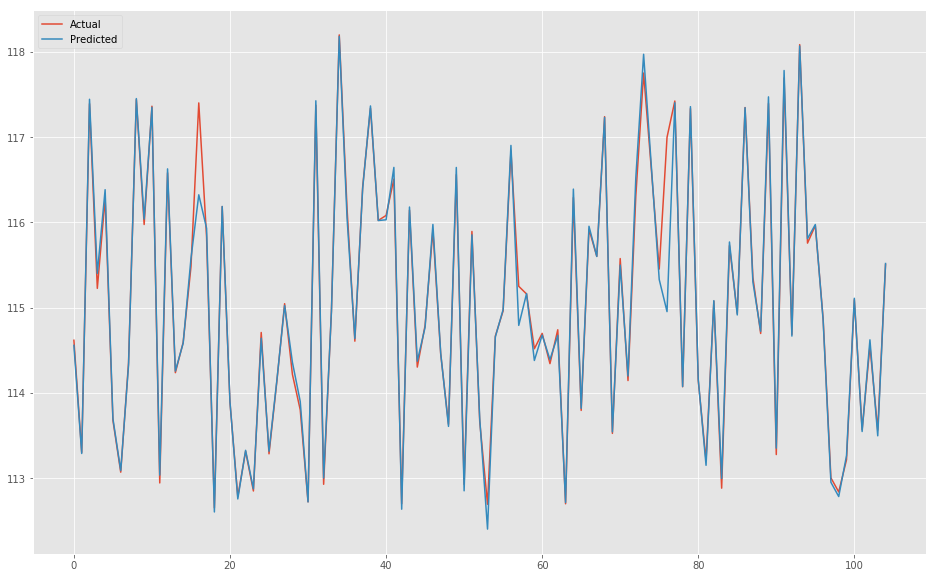

In [61]:
X_test = sm.tools.tools.add_constant(X_test, has_constant='add')
Y_test_p = mod.predict(X_test)
plt.figure(figsize=(16,10))
plt.plot(range(0,len(Y_test)),Y_test, label='Actual')
plt.plot(range(0,len(Y_test)),Y_test_p, label='Predicted')
plt.legend(loc='upper left')

## RSquared on the test data

In [62]:
r2_score(Y_test, Y_test_p)

0.9748871728487423

## Residuals and Assumption Validation

In [63]:
error = Y_test - Y_test_p

#### White Noise Residuals

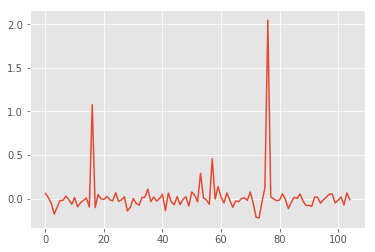

In [69]:
plt.plot(range(0,len(Y_test)),error)

Residuals are white noise with no real distribution.

#### No autocorrelation

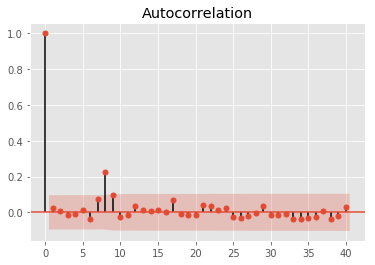

In [79]:
acf = smt.graphics.plot_acf(model.resid, lags=40 , alpha=0.05)
acf.show()

**The Durbin-Watson test gives a value of ~2 which means there is no autocorrelation.**

There shows that there is no autocorrelation between the residuals, neither is their any particular distribution which means there is no variance escaping out of the model.

#### Heteroskedasticity Test

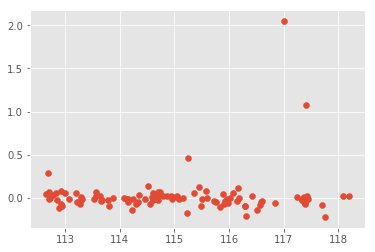

In [72]:
plt.scatter(Y_test,error)

No funnel or cone shaped pattern so no heteroskedasticity in the residuals.